In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

# Square layout, 2-component R-D system with fixed stoich

A reaction-diffusion model is a mathematical model which calculates the concentration of two substances at a given time based on the substances'

- diffusion
- feed rate (how fast the substances are being created by the reaction OR a source)
- removal rate (how fast the substances are being used up by the reaction OR a sink)
- type of reaction between the two

For the reaction $u + 2v \rightarrow 3v$ (i.e. two of species V come together to convert a single U into V) this is governed by the differential equations

\begin{equation}
\frac{\partial u}{\partial t} = r_u \nabla^2 u - uv^2 + f(1-u)
\end{equation}

\begin{equation}
\frac{\partial v}{\partial t} = r_v \nabla^2 v + uv^2 - (f+k)v
\end{equation}

Where $u$ and $v$ are the concentrations of the two reactants, f is the rate at which reactant u is fed into the system (by an outside source), k is the rate at which reactant v is removed from the system (by an outside sink), and $r_u$ and $r_v$ are the diffusion rates of $u$ and $v$ respectively.

The system after a finite time step $dt$ is therefore:

\begin{equation}
u_2 = u_1 + [r_u \nabla^2 u - uv^2 + f(1-u)]dt
\end{equation}

\begin{equation}
v_2 = v_1 + [r_v \nabla^2 v + uv^2 - (f+k)v]dt.
\end{equation}

In [17]:
# need an input grid of values (initial conditions)
initial = np.ones((100, 100, 1, 2))
initial[:,:50,0,1] = initial[:,:50,0,1]*0.0
initial[:,50:,0,0] = initial[:,:50,0,1]*0.0

## Advance the initial conditions by a single time step

In [59]:
# first need to define a laplacian kernel - we're going to do the laplacian by just convolving the whole arrays with
# this kernel. keep values flexible so we can play with them later. start with a 3x3

lap = np.array([[0.05, 0.2, 0.05],
                [0.2, -1, 0.2],
                [0.05, 0.2, 0.05]]) # values suggested by https://www.karlsims.com/rd.html

# define reaction and diffustion rate constants (these also need to be adjustable)
ru = 1.0
rv = 0.5
f = 0.055
k = 0.062

# time step (also a user input)
dt = 1.0

In [58]:
lap.shape

(1, 3, 3)

In [66]:
def time_step(frame_t1, dt, lap, ru, rv, f, k):
    '''function to move an initial grid of concentrations forward through the reaction-diffusion equations by 
       a single time step dt.
       
       Parameters
       ----------
       frame_t1: an (N x M x 1 x Q) numpy array where N,M are the lengths of the two spatial components,
                 and Q is the number of reactants.
       dt:       float, the length of the time step
       lap:      2D numpy array, the (I x J) kernel that will be convolved with the concentrations in place of 
                 performing a Laplacian.
       ru/rv:    the diffusion constants for reactant U and reactant V, respectively
       f:        float, the rate constant for the supply of reactant U
       k:        float, the rate constant for the removal of reactant V
       
       returns
       -------
       frame_t2: an (N x M x Q) numpy array where N,M are the lengths of the two spatial components,
                 and Q is the number of reactants. This will be frame_t1 moved forward by a time step dt
                 
    '''
    
    # start by moving U forward one time step
    lapu = convolve(frame_t1[:,:,0,0], lap, mode='constant', cval=0.0)
    diffterm = ru * lapu
    diffterm = diffterm[:,:,np.newaxis]

    reactterm = frame_t1[:,:,:,0] * frame_t1[:,:,:,1]**2

    sourceterm = f*(1 - frame_t1[:,:,:,0])

    frame_t2 = frame_t1[:,:,:,0] + (diffterm - reactterm + sourceterm)*dt
    
    # move V forward one time step
    lapv = convolve(frame_t1[:,:,0,1], lap, mode='constant', cval=0.0)
    diffterm = rv * lapv
    diffterm = diffterm[:,:,np.newaxis]

    # same reactterm as for U

    sinkterm = (f + k)*frame_t1[:,:,:,1]

    frame_t2 = np.stack((frame_t2, frame_t1[:,:,:,1] + (diffterm + reactterm - sinkterm)*dt), axis=-1)
    
    return frame_t2

In [76]:
def evolve(frame_t0, dt, nsteps, lap, ru, rv, f, k):
    '''function to move an initial grid of concentrations forward through the reaction-diffusion equations by 
       a single time step dt.
       
       Parameters
       ----------
       frame_t0: an (N x M x Q) numpy array where N,M are the lengths of the two spatial components,
                 and Q is the number of reactants. This should be the initial conditions
       dt:       float, the length of the time step
       nsteps:   int, the number of single time steps the function should move the system forward 
       lap:      2D numpy array, the (I x J) kernel that will be convolved with the concentrations in place of 
                 performing a Laplacian.
       ru/rv:    the diffusion constants for reactant U and reactant V, respectively
       f:        float, the rate constant for the supply of reactant U
       k:        float, the rate constant for the removal of reactant V
       
       returns
       -------
       final:    an (N x M x P x Q) numpy array where N,M are the lengths of the two spatial components,
                 Q is the number of reactants, and P=nsteps. This will be frame_t0 moved forward through a total
                 length of time dt*nsteps
                 
    '''
    
    # do the first step separately because it requires the initial array
    frame_tlast = time_step(frame_t0, dt, lap, ru, rv, f, k)
    final = frame_tlast
    
    # iterate through (1, nsteps), each time creating a new frame by moving the most recent frame forward through
    # time by dt and then appending this new frame onto the final array
    for step in range(1, nsteps):
        
        frame_tnext = time_step(frame_tlast, dt, lap, ru, rv, f, k)
        final = np.concatenate((final, frame_tnext), axis=2)
        
        frame_tlast = frame_tnext
    
    return final

In [87]:
test = evolve(initial, dt, 100, lap, ru, rv, f, k)

<IPython.core.display.Javascript object>


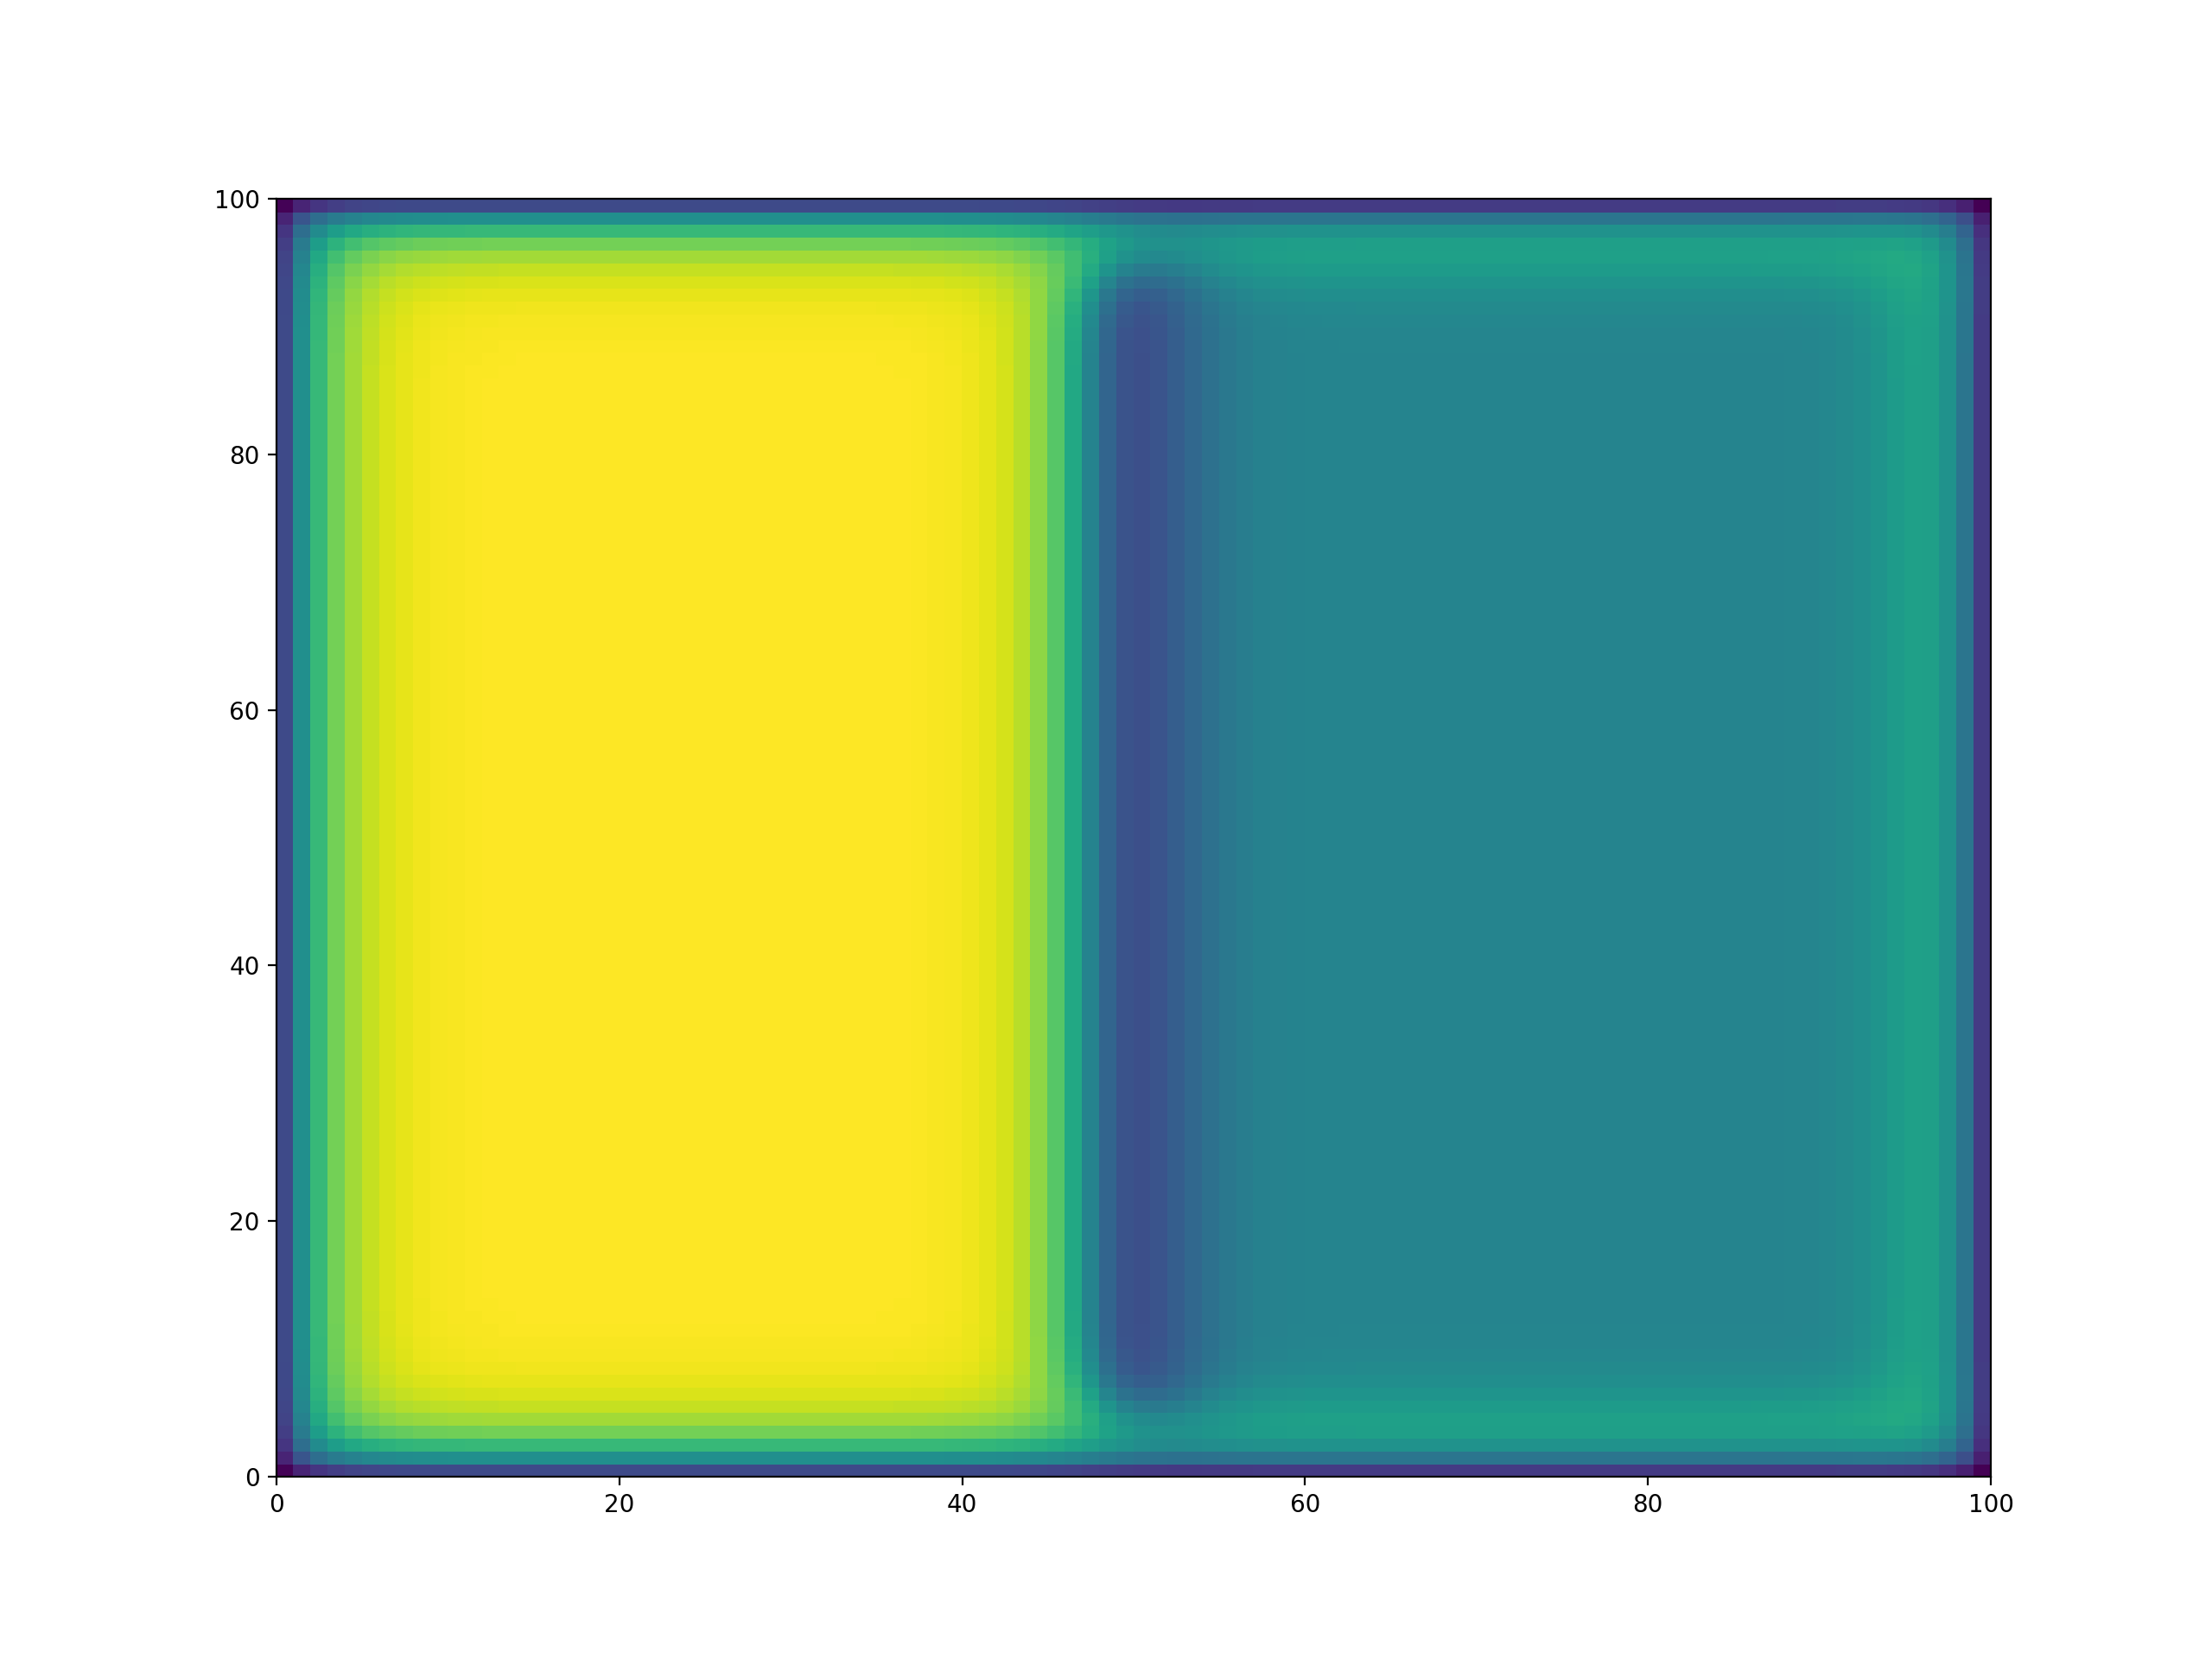

In [90]:
%matplotlib notebook

plt.pcolormesh(test[:,:,50,0])

In [43]:
for i in range(0, 30, 5):
    print(i)

0
5
10
15
20
25
